In [1]:
import pandas as pd
import mysql.connector
import os

csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

conn = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='Sarthak@03',
    database='ecommerce',
    auth_plugin='mysql_native_password'
)
cursor = conn.cursor()

folder_path = 'D:\SUHANE\Pandas\E-commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    df = pd.read_csv(file_path)
    
    df = df.where(pd.notnull(df), None)
    
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    for _, row in df.iterrows():
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    conn.commit()

conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect (host = "127.0.0.1", username = "root", password = "Sarthak@03", database = "ecommerce")
cur = db.cursor()

query = ''' select distinct customer_city from customers '''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [3]:
query = ''' select count(order_id) from orders where year(order_purchase_timestamp) = 2017 '''
cur.execute(query)
data = cur.fetchall()
data[0][0]

45101

In [4]:
query = ''' select upper(products.product_category) as category, round(sum(payments.payment_value),2) as sales
from products join order_items 
on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
group by category'''
cur.execute(query)
data = cur.fetchall()
data

[('PERFUMERY', 506738.66),
 ('FURNITURE DECORATION', 1430176.39),
 ('TELEPHONY', 486882.05),
 ('FASHION BAGS AND ACCESSORIES', 218158.28),
 ('BED TABLE BATH', 1712553.67),
 ('AUTOMOTIVE', 852294.33),
 ('COMPUTER ACCESSORIES', 1585330.45),
 ('HOUSEWARES', 1094758.13),
 ('BABIES', 539845.66),
 ('TOYS', 619037.69),
 ('FURNITURE OFFICE', 646826.49),
 ('COOL STUFF', 779698.0),
 ('HEALTH BEAUTY', 1657373.12),
 ('PET SHOP', 311268.97),
 ('GENERAL INTEREST BOOKS', 64694.76),
 ('STATIONARY STORE', 317440.07),
 ('WATCHES PRESENT', 1429216.68),
 ('PCS', 279121.55),
 ('CLIMATIZATION', 91170.66),
 ('CONSTRUCTION TOOLS CONSTRUCTION', 241475.63),
 ('SPORT LEISURE', 1392127.56),
 ('BAGS ACCESSORIES', 187151.29),
 ('ELECTRONICS', 259857.1),
 ('CASA CONSTRUCAO', 136645.29),
 ('GAMES CONSOLES', 195480.38),
 ('HOME APPLIANCES', 95532.27),
 ('GARDEN TOOLS', 838280.75),
 ('AGRO INDUSTRIA E COMERCIO', 118730.61),
 (None, 252801.71),
 ('AUDIO', 60324.62),
 ('TECHNICAL BOOKS', 24915.44),
 ('CONSTRUCTION TOOLS 

In [6]:
query = ''' select (sum(case when payment_installments > 1 then 1 else 0 end))/count(*)*100 from payments'''
cur.execute(query)
data = cur.fetchall()
data[0][0]

Decimal('49.4176')

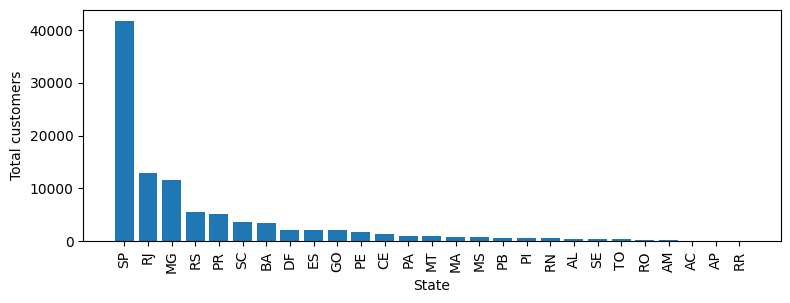

In [15]:
query = ''' select customer_state, count(customer_id)
from customers group by customer_state'''
cur.execute(query)
data = cur.fetchall()
plt.figure(figsize = (9,3))
df = pd.DataFrame(data, columns = ["State","Total customers"])
df = df.sort_values(by = "Total customers", ascending = False)
plt.bar(df["State"], df["Total customers"])
plt.xticks(rotation = 90)
plt.xlabel("State")
plt.ylabel("Total customers")
plt.show()

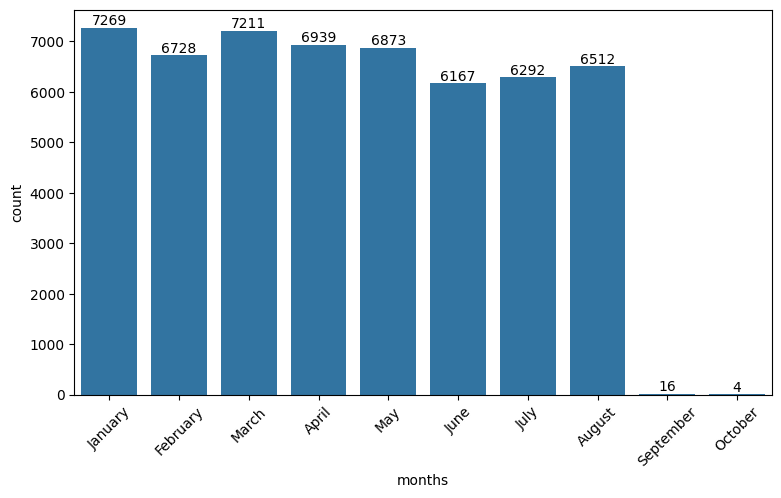

In [23]:
query = ''' select monthname(order_purchase_timestamp) as months, count(order_id) as count
from orders where year(order_purchase_timestamp) = 2018 group by months'''
cur.execute(query)
data = cur.fetchall()
plt.figure(figsize = (9,5))
df = pd.DataFrame(data, columns = ["months","count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]
df = df.sort_values(by = "count", ascending = False)
ax = sns.barplot(x = df["months"], y = df["count"], data = df, order = o,)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.show()

In [27]:
query = ''' with opp as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(opp.oc),2) average_orders
from customers join opp
on customers.customer_id = opp.customer_id
group by customers.customer_city order by average_orders desc '''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_city","average"])
df.head(5)


,customer_city,average
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00


In [29]:
import numpy as np
query = ''' select products.product_category, count(order_items.product_id), round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id group by products.product_category'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])
arr1 = df["order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1,arr2])
a[0][-1]

-0.10631514167157562

In [30]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


In [31]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


In [32]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


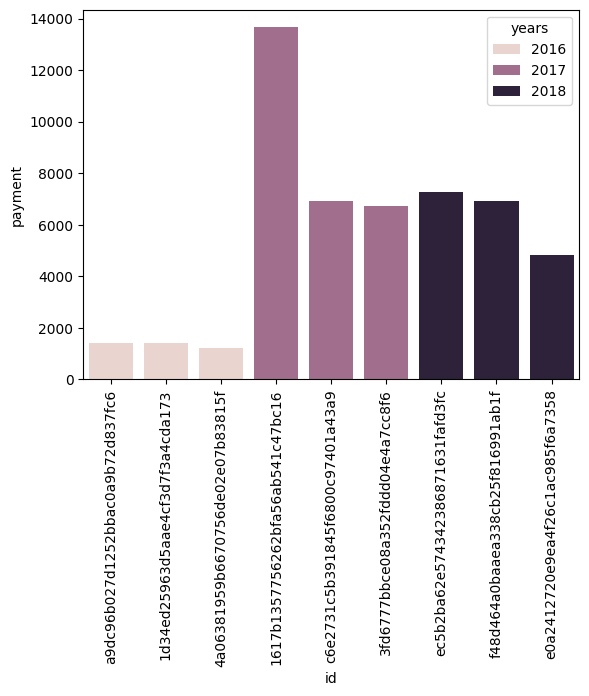

In [33]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()